In [43]:
import itertools
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
sys.path.append("../src")
import pandas as pd
import json
from matplotlib import pyplot as plt

In [44]:
from glob import glob
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator"
checkpoint_name = "metrics_test.jsonl"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)


print(len(files))

1468


In [82]:

def expand(idx,chunk):
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

experiments = []
for file in files:
    chunks = file.split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data["train_percentage"] = float(data["train_percentage"])*100 if data["train_percentage"] != "null" else 100.0
    if "clean" in file and "noisy" in file:
        print(file)
    if data["version"].startswith("v2.2_clean_noisy"):
        experiments.append(data)

print(len(experiments))

/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-1/metrics_test.jsonl
/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-2/metrics_test.jsonl
/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-3/metrics_test.jsonl
3


In [83]:
from collections import defaultdict


for experiment in tqdm(experiments):
    all_raw = []
    all_breakdown = defaultdict(dict)
    em = 0.0
    with open(experiment['file']) as f:
        for line in f:
            partial_results = json.loads(line)
            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["breakdown_prop"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["breakdown_type"].items())


    experiment["EM"] = np.mean([rec[2] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)


    experiment["raw"] = all_raw


    avg = []
    for k,v in experiment.items():
        if k.startswith("type_negative"):
            avg.append((experiment["count_{}".format(k)], v))

    support, ems = zip(*avg)
    experiment["x_avg_negative"] = np.average(a=ems,weights=support)



In [84]:
results = pd.DataFrame(experiments).fillna(0)

cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "A_EM" or col == "EM" or col.startswith("x_") or col.startswith("prop_") or col.startswith("type_"),results.columns)}
cols.update({col:[np.max] for col in filter(lambda col: col.startswith("count_type_negative"), results.columns)})
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
type_cols = list(filter(lambda col: (col.startswith("type_") and "negative" not in col) or col.startswith("x"),results.columns))
print(type_cols)
type_cols2 = list(filter(lambda col: col.startswith("type_") and "negative" not in col or col == "x_avg_negative",results.columns))
a_type_cols = list(filter(lambda col: col.startswith("A_type_") and "negative" not in col or col == "x_avg_negative",results.columns))
type_cols3 = list(filter(lambda col: "count" not in col and  "negative" in col,results.columns))
type_cols4 = list(filter(lambda col: col.startswith("type_") and "negative" not in col,results.columns))
breakdown = pd.pivot_table(results, index=["experiment","version","model","lr","filters","train_percentage"],columns=[],aggfunc=cols)
#pd.option_context("display.max_rows",None)
pd.options.display.max_rows = 150
breakdown

['type_count', 'type_argmax', 'type_set', 'type_atomic_boolean', 'type_join_boolean', 'type_argmin', 'type_atomic_extractive', 'type_join_extractive', 'x_avg_negative']


EM  \
                                                                           mean   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.762531   

                                                                                 \
                                                                            std   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.017834   

                                                                      count_type_negative  \
                                                                                     amax   
experiment     version          model   lr   filters train_percentage                       
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0                            969   

                                                                      count_type_negative2  \
                                                                                      amax   
experiment     version          model   lr   filters train_percentage                        
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0                             599   

                                                                      prop_P106  \
                                                                           mean   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.688526   

                                                                                 \
                                                                            std   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.020087   

                                                                      prop_P108  \
                                                                           mean   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.873912   

                                                                                 \
                                                                            std   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.013786   

                                                                      prop_P1082  \
                                                                            mean   
experiment     version          model   lr   filters train_percentage              
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0               0.66778   

                                                                                 \
                                                                            std   
experiment     version          model   lr   filters train_percentage             
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             0.023981   

                                                                       ...  \
                                                                       ...   
experiment     version          model   lr   filters train_percentage  ...   
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0             ...   

                                                                      type_join_extractive  \
                                                                                      mean   
experiment     version          model   lr   filters train_percentage                        
operator_sweep v2.2_clean_noisy t5-base 8e-5 null    100.0      

In [37]:
display = "v1.3.2"

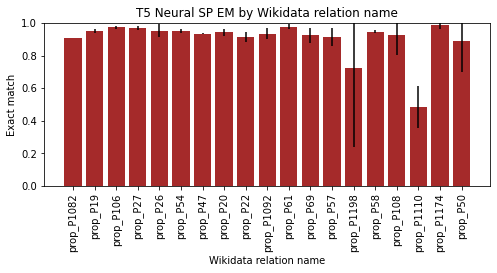

In [38]:

prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][100].T[breakdown_cols]

means = []
stds = []

for score in [prop_scores[a] for a in breakdown_cols]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.figure(figsize=(8,3))
plt.xticks(rotation=90)
plt.title("T5 Neural SP EM by Wikidata relation name")
plt.ylabel("Exact match")
plt.xlabel("Wikidata relation name")

plt.bar(breakdown_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
plt.savefig("/scratch/jth/neural_sp_rels.pdf", bbox_inches = 'tight')
plt.show()


[0.770908070612795]
[0.008206017532569068]


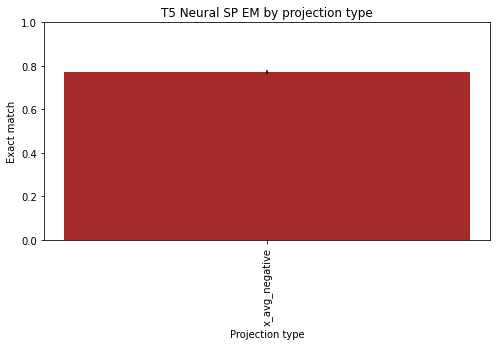

In [39]:
prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][100.0].T[a_type_cols]

means = []
stds = []

sort_cols = sorted(a_type_cols)
for score in [prop_scores[a] for a in sort_cols]:
    means.append(score["mean"])
    stds.append(score["std"])


plt.figure(figsize=(8,4))
plt.xticks(rotation=90)

plt.title("T5 Neural SP EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.bar(sort_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
print(means)
print(stds)
plt.savefig("/scratch/jth/neural_sp_proj.pdf", bbox_inches = 'tight')
plt.show()

In [72]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.title("T5 Operator model negative instance EM by negative type")

x = np.arange(len(type_cols2))
w = 0.2
plt.xticks(x+w/5, type_cols2,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

    means = []
    stds = []

    for score in [prop_scores[a] for a in type_cols2]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

plt.ylim(0,1)
plt.legend(datasets)
plt.show()

KeyError: 'null'

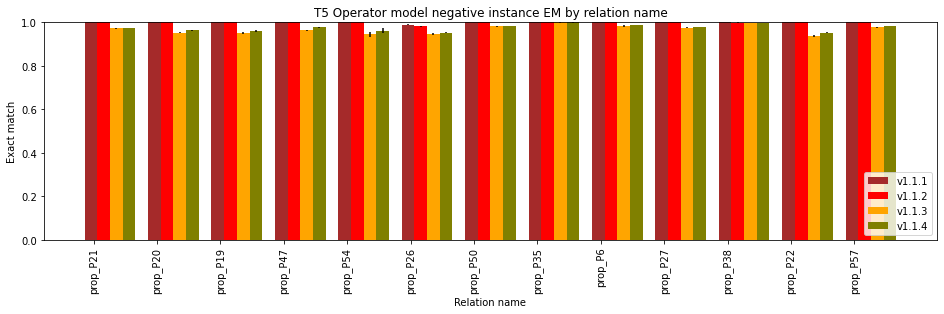

In [64]:

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by relation name")
plt.ylabel("Exact match")
plt.xlabel("Relation name")
plt.title("T5 Operator model negative instance EM by relation name")

x = np.arange(len(breakdown_cols))
w = 0.2
plt.xticks(x+w/5, breakdown_cols,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[breakdown_cols]

    means = []
    stds = []

    for score in [prop_scores[a] for a in breakdown_cols]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

print(means)
plt.ylim(0,1)
plt.legend(datasets, loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")


prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

means = []
stds = []

for score in [prop_scores[a] for a in type_cols2]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.bar(type_cols2,means,yerr=stds)

plt.ylim(0,1)
plt.show()




In [112]:
prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][100.0].T[type_cols3]

means = []
stds = []
matched = []
props = []

w = 0.3
for name in type_cols3:

    try:
        score =  prop_scores[name]
        matched.append(name)
        means.append(score["mean"])
        stds.append(score["std"])

    except:
        print("No instances for {}".format(name))

    if "x" not in name:
        props.append(breakdown.T["operator_sweep"]["t5-base"]["null"][100.0]["count_{}".format(name)]["amax"])
    else:
        props.append(0.0)


fig,ax1 = plt.subplots(figsize=(16,4))

x = np.arange(len(matched))

plt.xticks(x+w/2, matched,rotation=90)
plt.title("T5 Operator model negative instance EM by negative type")
ax1.set_ylabel("Exact match")
ax1.set_xlabel("Projection type")

ems = ax1.bar(x, means, yerr=stds, width=w)

ax2 = plt.twinx()
sizes = ax2.bar(x+w, props, color="orange", width=w)
ax1.set_ylabel("Number of data")

plt.legend([ems,sizes],['EM Score','Number of data'])
ax1.set_ylim(0,1)
ax2.set_ylim(0,600)
plt.show()

KeyError: 't5-base'

['prop_P69', 'prop_P19', 'prop_P20', 'prop_P108', 'prop_P47', 'prop_P1082', 'prop_P54', 'prop_P106', 'prop_P21', 'prop_P57', 'prop_P61', 'prop_P22', 'prop_P118', 'prop_P6', 'prop_P26', 'prop_P58', 'prop_P1174', 'prop_P38', 'prop_P35', 'prop_P50', 'prop_P1092', 'prop_P1198', 'prop_P1110']


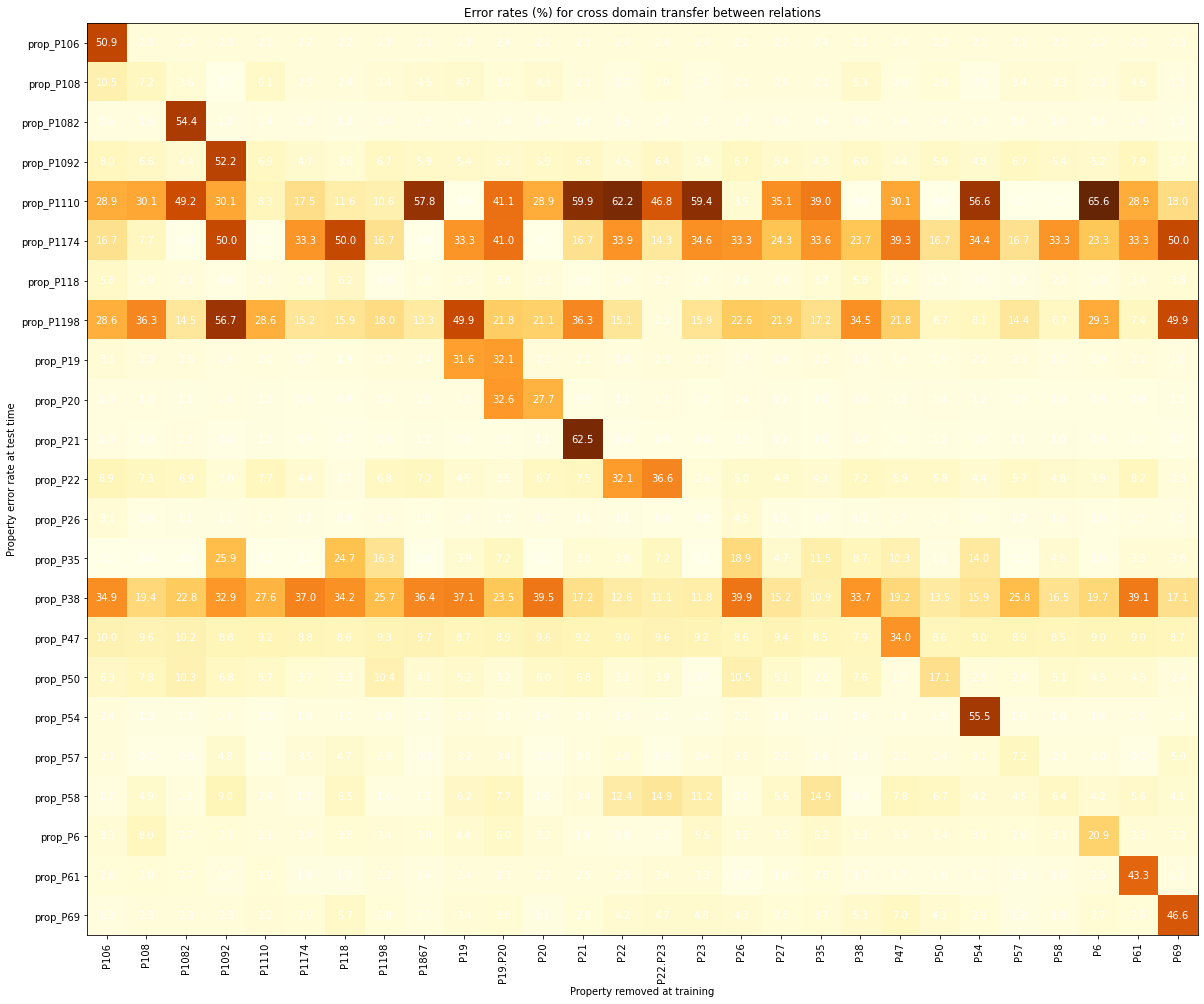

In [54]:
breakdown_cols= list(filter(lambda col: col!= "P1867" and col!="prop_P1867",breakdown_cols))
print(breakdown_cols)
cols2 = list(set(map(lambda a: a[0], filter(lambda col:col[0] != "null", breakdown.T["operator_filter"]["v1.3.2"]["t5-base"]["8e-5"].columns))))

x_labels = sorted(cols2)
y_labels = sorted(breakdown_cols)

heatmap = []

for c in y_labels:
    row = []
    for x in x_labels:
        row.append(breakdown.T["operator_filter"]["v1.3.2"]["t5-base"]["8e-5"][x][100.0].T[c]["mean"])
    heatmap.append(row)

heatmap=np.array(heatmap)

assert heatmap.shape[0] == len(y_labels)
assert heatmap.shape[1] == len(x_labels)

fig, ax = plt.subplots(figsize=(16,16))
im = ax.imshow(1-heatmap, cmap="YlOrBr")

fig.tight_layout()
plt.xticks(np.arange(len(x_labels)),x_labels,rotation=90)
plt.yticks(np.arange(len(y_labels)),y_labels)

for j in range(len(x_labels)):
    for i in range(len(y_labels)):
        text = ax.text(j,i, round(100*(1-heatmap[i,j]),1),color='w', ha="center",va="center")


plt.xlabel("Property removed at training")
plt.ylabel("Property error rate at test time")
plt.title("Error rates (%) for cross domain transfer between relations")
plt.savefig("/scratch/jth/neural_sp_trans.pdf", bbox_inches = 'tight')
plt.show()


('operator_filter', 'v1.4', 't5-base', '8e-5', 'P106', 100.0)
[1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 100.0]


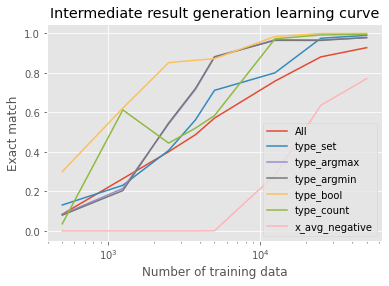

In [42]:
import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    print(breakdown.index[0])
    display = "v1.4"
    sizes = [a[5] for a in breakdown.index if a[1] == display and a[3] == "8e-5" and a[4] == "null" and a[5] != "null"]
    print(sizes)

    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][sizes].T["EM"]

    means = []
    uppers = []
    lowers = []

    for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
        means.append(mean)
        lowers.append(mean-std)
        uppers.append(mean-std)


    plt.figure(figsize=(6,4))

    actual = [550000*size/100 for size in sizes]
    plt.title("Intermediate result generation learning curve")
    plt.ylabel("Exact match")
    plt.xlabel("Number of training data")

    plt.plot(actual,means)
    plt.fill_between(actual,lowers,uppers,alpha=0.2)
    plt.xscale("log")


    legend = ["All"]
    for line in type_cols2:
         prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][sizes].T[line]
         means = []
         uppers = []
         lowers = []

         for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
             means.append(mean)
             lowers.append(mean-std)
             uppers.append(mean-std)


         plt.plot(actual,means)
         plt.fill_between(actual,lowers,uppers,alpha=0.2)
         legend.append(line)



    plt.legend(legend)
    plt.savefig("/scratch/jth/neural_sp_data.pdf", bbox_inches = 'tight')
    plt.show()


In [ ]:
    def get_num(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[1].strip()
        else:
            return None

    def get_ent(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[0].strip().replace("[LOOKUP]","").strip()
        else:
            return None

    err_predict_null =0
    err_wrong_num = 0
    err_wrong_ent = 0

    for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"], experiments):
        for item in exp["raw"]:
            if "[SEP]" in item[0]:
                master = get_num(item[0])
                predicted = get_num(item[1])

                if predicted is None:
                    err_predict_null += 1

                elif predicted != master:
                    err_wrong_num += 1

                    print(predicted,master)

            if "[SEP]" in item[0]:
                master = get_ent(item[0])
                predicted = get_ent(item[1])

                if predicted is None:
                    pass
                elif predicted != master:
                    err_wrong_num += 1
                    print(predicted,master)


    print(err_wrong_num, err_predict_null)

In [86]:

print("FALSE NEGATIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v2.2" in exp["file"], experiments):
    for item in exp["raw"]:
    # for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[0] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            #print("*"*80)
            #print("Score\t\t",item[2])
            #print("Query\t\t",item[3]["query"])
            #print("Fact\t\t",item[3]["fact"])
            #print("Projection\t\t",item[3]["projection"])
            ##print("Projection (tokenized)\t\t", item[1])
            #print("Predicted (tokenized)\t\t", item[0])



print(type_counts)

FALSE NEGATIVES
defaultdict(<class 'int'>, {'count': 2872, 'argmax': 3875, 'set': 3162, 'argmin': 3757, 'negative2': 2})


In [85]:
import random
from collections import defaultdict

print("FALSE POSITIVES")
type_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v2.2_clean_noisy" in exp["file"], experiments):
    for item in random.sample(exp["raw"],k=100):
        if "[NULL_ANSWER]" in item[1] and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            # print("*"*80)
            # print("Score\t\t",item[2])
            # print("Query\t\t",item[3]["query"])
            # print("Type\t\t",item[3]["type"])
            # print("Fact\t\t",item[3]["fact"])
            # print("Projection\t\t",item[3]["projection"])
            # print("Projection (tokenized)\t\t", item[1])
            # print("Predicted (tokenized)\t\t", item[0])



print(type_counts)

FALSE POSITIVES
defaultdict(<class 'int'>, {'negative2': 1})


In [88]:
import random
from collections import defaultdict

print("TRANS ERROR")
type_counts = defaultdict(int)
proj_counts = defaultdict(int)
for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"] and "v2" in exp["file"], experiments):
    for item in exp["raw"]:
        if item[1]!= "[NULL_ANSWER]" and item[0] != "[NULL_ANSWER]" and item[2]<1:
            test_instance = item[3]
            type_counts[test_instance["type"]] +=1
            # if "prop" in test_instance and test_instance["prop"] == "P47":
            #     continue
            #
            #
            # print("*"*80)
            # print("Score\t\t",item[2])
            # print("Query\t\t",item[3]["query"])
            # print("Type\t\t",item[3]["type"])
            # print("Fact\t\t",item[3]["fact"])
            # print("Projection\t\t",item[3]["projection"])
            # print("Projection (tokenized)\t\t", item[1])
            # print("Predicted (tokenized)\t\t", item[0])


    break

print(type_counts)
print(proj_counts)
print(sum(type_counts.values()))


TRANS ERROR
defaultdict(<class 'int'>, {'count': 103, 'argmax': 62, 'argmin': 72, 'set': 100, 'atomic_extractive': 32, 'atomic_boolean': 32, 'join_boolean': 3, 'join_extractive': 1})
defaultdict(<class 'int'>, {})
405
